In [1]:
import numpy as np
import pandas as pd 
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set_theme(style="darkgrid")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Maintenant que nous avons posé la problématique, récupérer des données fiables pour y répondre et réaliser un ETL sur ces données afin de les stocker de manière pérenne et performante et de les stocker sous un format propice à l'analyse.

Nous pouvons maintenant réaliser l'analyse exploratoire des données afin de décrire le jeu de données et de construire des hypothèse sur celui-ci.

In [2]:
conn = sql.connect('frequentation_dtwh.db')

## Reconstruction du dataset global à partir du DTWH

In [3]:
import time
start_time = time.time()

cursor = conn.cursor() 

SQL_Query = pd.read_sql_query(
    '''select 
Frequentation_quotidienne.date, 
Frequentation_quotidienne.prevision, 
Frequentation_quotidienne.reel,
Dim_site.*,
Dim_menu.plats,
Dim_temporelle.vacances_dans, 
Dim_temporelle.depuis_vacances,
Dim_temporelle.ferie_dans, 
Dim_temporelle.depuis_ferie, 
Dim_temporelle.chretiennes_dans,
Dim_temporelle.depuis_chretiennes,
Dim_temporelle.juives_dans,
Dim_temporelle.depuis_juives, 
Dim_temporelle.ramadan_dans, 
Dim_temporelle.depuis_ramadan, 
Dim_temporelle.musulmanes_dans, 
Dim_temporelle.depuis_musulmanes,
Dim_evenement.chretiennes, 
Dim_evenement.juives,
Dim_evenement.ramadan, 
Dim_evenement.musulmanes, 
Dim_evenement.greve

from Frequentation_quotidienne

left join Dim_site               on Frequentation_quotidienne.site_id = Dim_site.site_id
left join Dim_menu               on Frequentation_quotidienne.jour_id = Dim_menu.jour_id
left join Dim_temporelle         on Frequentation_quotidienne.jour_id = Dim_temporelle.jour_id
left join Dim_evenement          on Frequentation_quotidienne.jour_id = Dim_evenement.jour_id

order by Frequentation_quotidienne.jour_site_id
''', conn)

data = pd.DataFrame(SQL_Query, columns=['date', 'prevision', 'reel', 'site_type', 'cantine_nom',
                                        'annee_scolaire', 'effectif', 'quartier_detail',
                                        'prix_quartier_detail_m2_appart', 'prix_moyen_m2_appartement',
                                        'prix_moyen_m2_maison', 'longitude', 'latitude',
                                        'vacances_dans', 'depuis_vacances',
                                        'plats',
                                        'ferie_dans', 'depuis_ferie', 'chretiennes_dans', 'depuis_chretiennes',
                                        'juives_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan',
                                        'musulmanes_dans', 'depuis_musulmanes',
                                        'chretiennes', 'juives',
                                        'ramadan', 'musulmanes', 'greve'])

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.1310935020446777 seconds ---


La requete sur l'ensemble du datawarehouse a été réalisé en 1 seconde pour un peu moins de 100k lignes et 30 colonnes.

Réalisons maintenant l'analyse exploratoire des données.

In [4]:
# sanity check
print(data.shape)
data['date'] = pd.to_datetime(data['date'])
data.head()

(91082, 31)


,date,prevision,reel,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,vacances_dans,depuis_vacances,plats,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve
0,2011-01-03,210.0,182.0,M/E,FRANCOISE DOLTO,2010-2011,191,Nantes Nord,3143.0,3208.0,3333.0,1.5795,47.2652,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
1,2011-01-03,100.0,93.0,E,CHENE D'ARON E,2015-2016,149,Centre ville,4200.0,4430.0,4376.0,1.5609,47.2122,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
2,2011-01-03,267.0,241.0,E,ANATOLE DE MONZIE,2014-2015,124,Ile de Nantes,3207.0,3089.0,4189.0,1.5418,47.2029,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
3,2011-01-03,197.0,184.0,M/E,ANDRE LERMITE/LAMORICIERE,2015-2016,334,None,NaN,NaN,NaN,NaN,NaN,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
4,2011-01-03,271.0,227.0,M,GASTON SERPETTE M,2017-2018,116,Hauts Pavés - Saint Félix,4131.0,3741.0,4792.0,1.5765,47.2263,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0


La granularité du dataframe est le jour couplé à une cantine en particulier. La cible est la fréquentation réelle : 'reel'.


## Analyse

Nous allons analyser les éléments suivants :

- La variable cible
- Les types de variables (catégoriques et numériques)
- Données manquantes
- Variables numériques :
    - Discrètes
    - Continues
    - Distributions
    - Transformations
- Variables catégorielles :
    - Cardinalité
    - Les catégories peu fréquentes
    
    
## La cible


Attention : ici, il ne s'agit pas d'un jeu de données traditionel :
- la granularité est double : jours et cantines
- ici, nous allons aggréger les données par jour pour pouvoir réaliser une première analyse 
- ensuite, nous allons aggréger les données par cantines pour suivre un deuxième axe d'analyse


### Analyse de la série temporelle aggrégée

In [5]:
# groupons les données par date
time_serie = data.groupby('date').reel.sum()

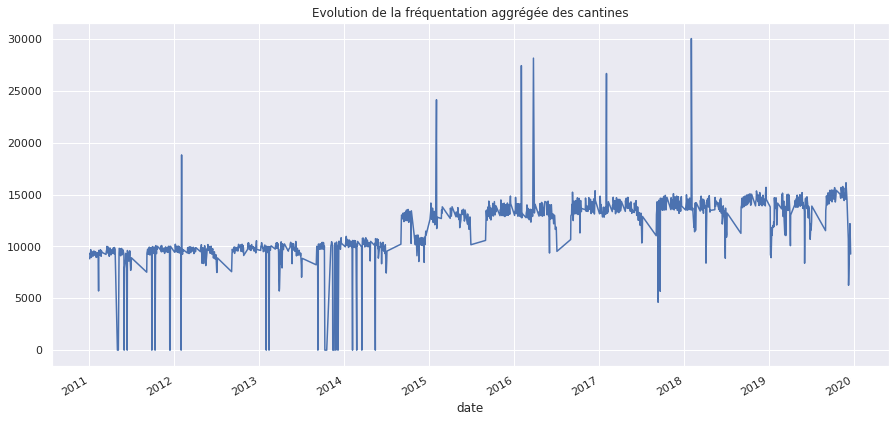

In [6]:
plt.figure(figsize=(15, 7))
plt.title('Evolution de la fréquentation aggrégée des cantines')
time_serie.plot();

De toute évidence, la série temporelle n'est pas continue : les vacances, les jours fériés, certains outliers... viennent y ajouter un caractère hératique.

Afin d'en tirer de vraies conclusions, il est nécessaire de réalisé de la décomposer.

Une série temporelle est communément décomposée en:
- une tendance correspondant à une évolution à long terme de la série (tendance linéaire, quadratique, logarithmique...)
- une saisonnalité correspondant à un phénoméne périodique de période identifiée
- une erreur qui est la partie aléatoire de la série (idéalement stationnaire)

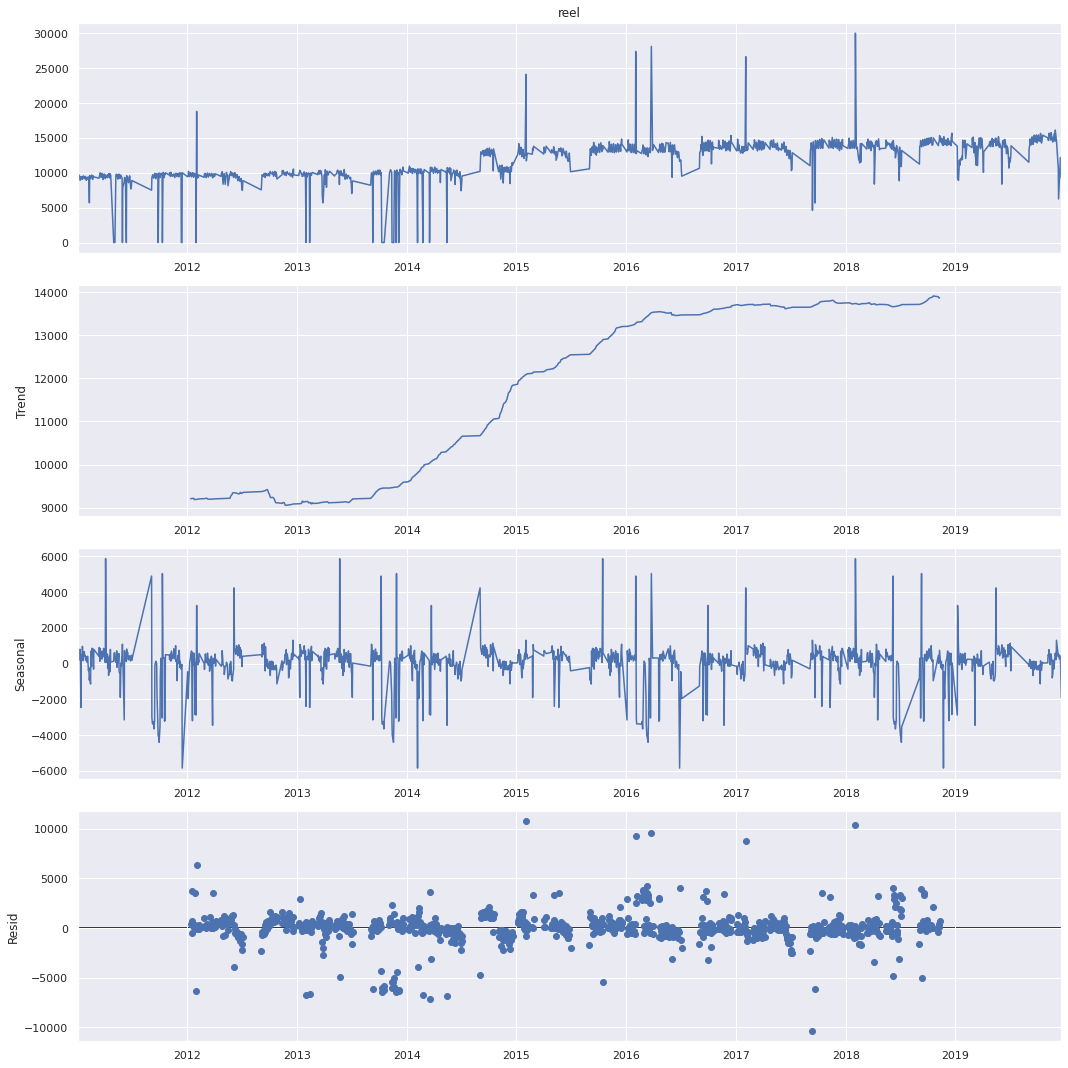

In [7]:
# decomposition de la série temporelle

plt.rc("figure", figsize=(15,15))
# on considère une fréquence annuelle
decomposed = sm.tsa.seasonal_decompose(time_serie,period=300)
figure = decomposed.plot()
plt.show()

Cette décomposition révèle plusieurs enseignements :
- il y a belle est bien un tendance haussière de fond, notamment entre 2014 et 2016.
- d'année en année, on retrouve les mêmes fortes variations saisonnières qui correspondent à des vacances, des jours fériés ou des annomalies.
- enfin on retrouve un forte concentration des résidus autour de 0, ce qui est rassurant, cependant la présence de quelques résidus importants est bien réelle.

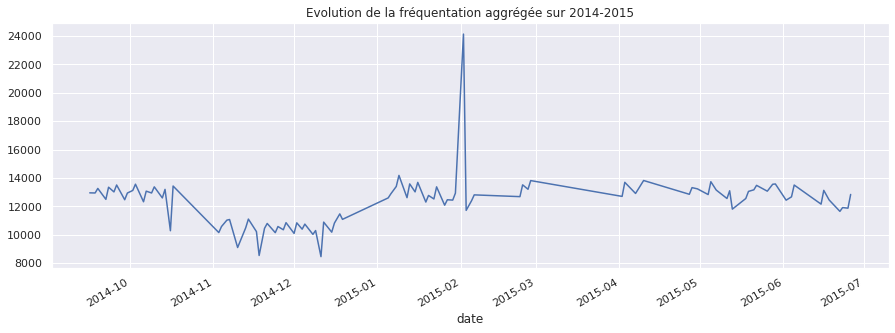

In [8]:
# voyons une année scolaire en particulier

plt.figure(figsize=(15, 5))
plt.title('Evolution de la fréquentation aggrégée sur 2014-2015')
time_serie[520:620].plot();

Un point centrale de l'anlyse es séries temporelles est de déterminer le décalage auquel la corrélation est significative est d'utiliser les graphiques ACF (fonction d'autocorrélation) et PACF (fonction d'autocorrélation partielle).
- L'ACF explique comment la valeur actuelle d'une série chronologique donnée est corrélée avec les valeurs passées (par rapport à t-1, par rapport à t-2...). 
- La PACF explique la corrélation des résidus (qui restent après avoir éliminé les effets qui sont déjà expliqués par l'ACF).

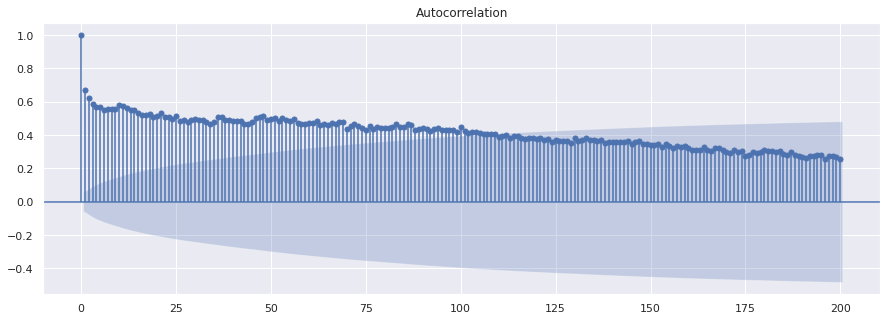

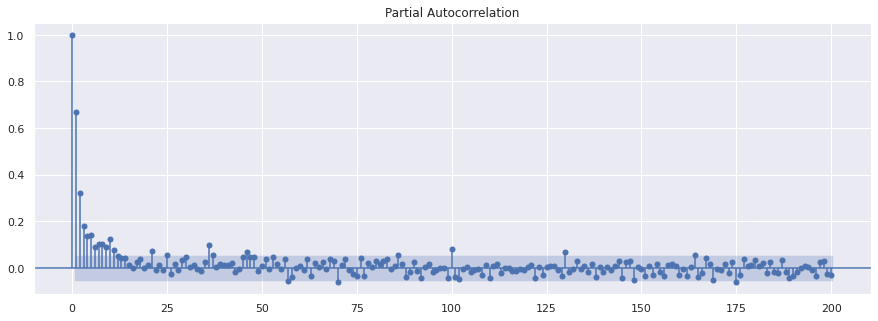

In [9]:
plt.rc("figure", figsize=(15,5))
plot_acf(time_serie, lags=200)
plot_pacf(time_serie, lags=200);

Remarquez que nous avons une bonne corrélation positive jusqu'au 100ème lag environ, c'est le point où le graphique ACF coupe le seuil de confiance supérieur. Bien que nous ayons une bonne corrélation jusqu'à ce lag, nous ne pouvons pas tous les utiliser car cela créerait un problème de multi-collinéarité, c'est pourquoi nous nous tournons vers le graphique PACF pour obtenir seulement les lags les plus pertinents...

En effet, les retards supérieurs à l'intervalle de confiance sont statistiquement significatifs. Bien qu'ils soient statistiquement significatifs, l'autocorrélation partielle après les 12 premiers lags est très faible.

Quid de la création de features basé sur les retards ? 

L’objectif est d’utiliser les données de la cuisine centrale et d’autres données pour modéliser la fréquentation des cantines de Nantes et la prédire plus fiablement deux à trois semaines à l’avance. Retenons la limite base de deux semaines. Cela correspond donc à 10 jours ouvrés. Non n'aurons donc pas à disposition c'est les features de lag 1 à lag 10 au moment de réaliser la prédiction.

Ceci étant dit nous pouvons dériver quelques features au dela de lag 10 pour voir leur impact sur le modèle.

En revanche, il est d'usage dans les séries temporelles traitées par le machine learning de dériver des features comme des statistiques descriptives sur une fenêtre mobile. Cela n'est pas possible ici car nous n'avons pas accés à la fenêtre de données allant du jour à prédire jusqu'à dix jours ouvrés en arrière.

### Analyse de la temporalité par cantine

In [10]:
# plt.figure(figsize=(15, 7))

# for cantine in data['cantine_nom']:
#     try:
#         time_serie = data[data['cantine_nom']==cantine].groupby('date').reel.sum()
#         decomposed = sm.tsa.seasonal_decompose(time_serie,period=360)
#         figure = decomposed.plot()
#         plt.show()
#     except:
#         pass

### Analyse de distribution de la cible

Skewness: 1.028584
Kurtosis: 2.923727


/home/quentin/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


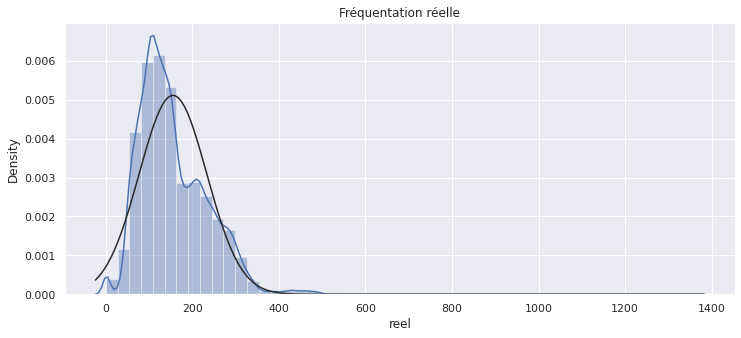

In [11]:
# Skew and kurt
print("Skewness: %f" % data['reel'].skew())
print("Kurtosis: %f" % data['reel'].kurt())

# histogran to evaluate target distribution
plt.rcParams["figure.figsize"] = 12,5

plt.title('Fréquentation réelle')
sns.distplot(data['reel'], fit=stats.norm);

Nous pouvons voir que la cible est continue, et que la distribution est étalée vers la droite
Nous pouvons améliorer celle-ci par une transformation statistique. Ici, la cible comporte des valeurs nulles nous ne pouvons donc pas utiliser le logarithme. Cependant, on peut utiliser la racine carrée ou le log(1+x).

Skewness: -0.017150
Kurtosis: 0.953154


/home/quentin/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


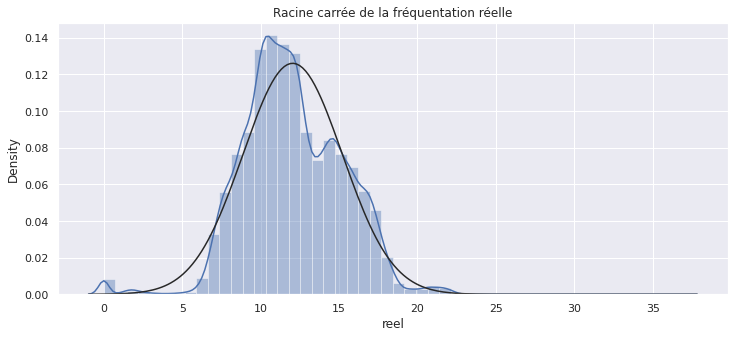

In [12]:
# Skew and kurt
print("Skewness: %f" % (data['reel']**(1/2)).skew())
print("Kurtosis: %f" % (data['reel']**(1/2)).kurt())

plt.title('Racine carrée de la fréquentation réelle')
sns.distplot((data['reel']**(1/2)), fit=stats.norm);

Maintenant la distribution semble davantage gaussienne, ce qui pourra aidé les modèles machine learning dans leur apprentissage.

## Les types de variables

Après étude de la cible, identifions maintenant les types des variables à disposition.

In [13]:
cat_feats = [var for var in data.columns if data[var].dtype == 'O']
cat_feats.remove('plats')

In [35]:
num_feats = [var for var in data.columns if var not in cat_feats and var !=
            'reel' and var != 'date']
num_feats

['prevision',
 'effectif',
 'prix_quartier_detail_m2_appart',
 'prix_moyen_m2_appartement',
 'prix_moyen_m2_maison',
 'longitude',
 'latitude',
 'vacances_dans',
 'depuis_vacances',
 'plats',
 'ferie_dans',
 'depuis_ferie',
 'chretiennes_dans',
 'depuis_chretiennes',
 'juives_dans',
 'depuis_juives',
 'ramadan_dans',
 'depuis_ramadan',
 'musulmanes_dans',
 'depuis_musulmanes',
 'chretiennes',
 'juives',
 'ramadan',
 'musulmanes',
 'greve']

## Corrélation entre les variables et la cible

<AxesSubplot:>

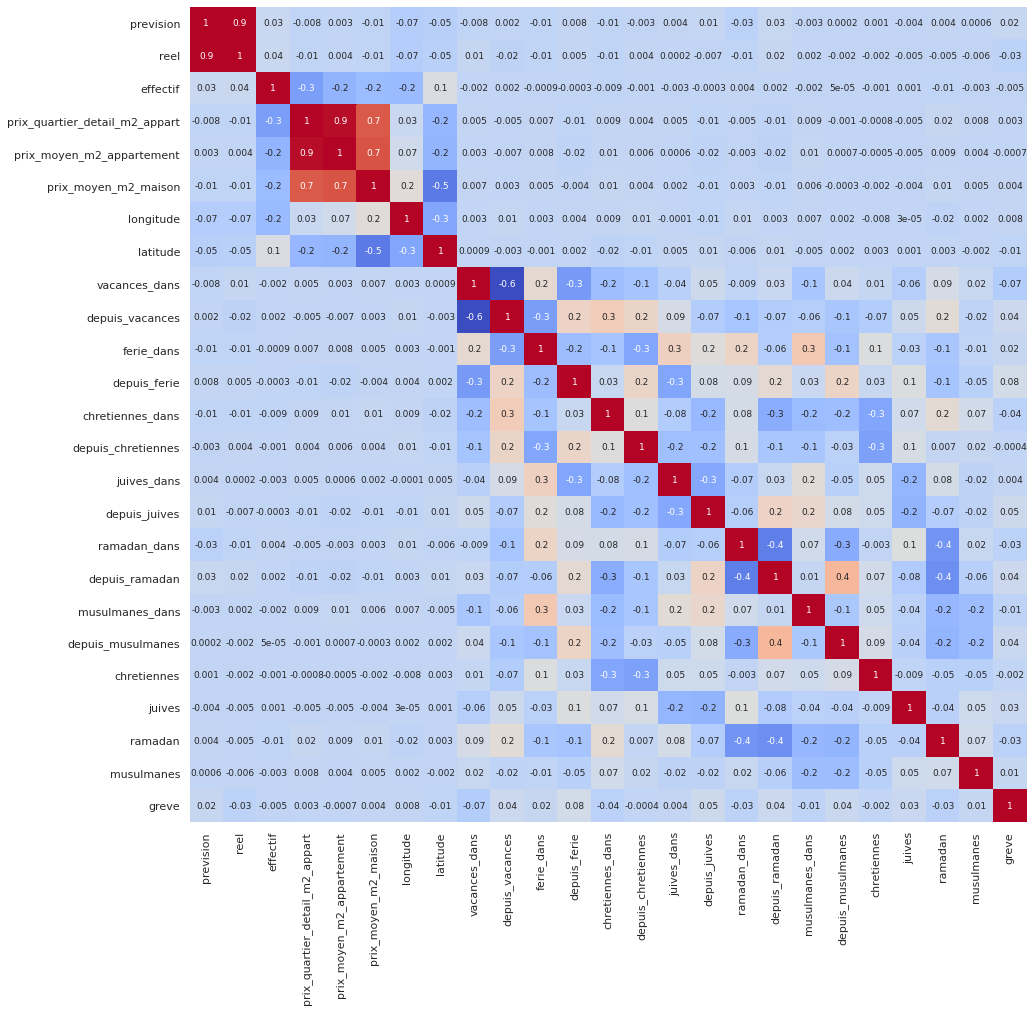

In [36]:
corr = data.corr()
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, vmax=0.9, cmap="coolwarm", annot=True, fmt=".1g", annot_kws={
            "size": 9}, linecolor='black', cbar=False)

## Les valeurs manquantes

Examinons de plus près les valeurs manquantes, car celles-ci peuvent être informatives en soit et requièrent un traitement spécifique avant la modélisation.

In [37]:
# make a list of the variables that contain missing values
na_feats = [var for var in data.columns if data[var].isnull().sum() > 0]
data[na_feats].isnull().mean().sort_values(ascending=False)

latitude                          0.131969
longitude                         0.131969
prix_moyen_m2_maison              0.131969
prix_moyen_m2_appartement         0.131969
prix_quartier_detail_m2_appart    0.131969
quartier_detail                   0.131969
plats                             0.061626
prevision                         0.026328
reel                              0.024758
dtype: float64

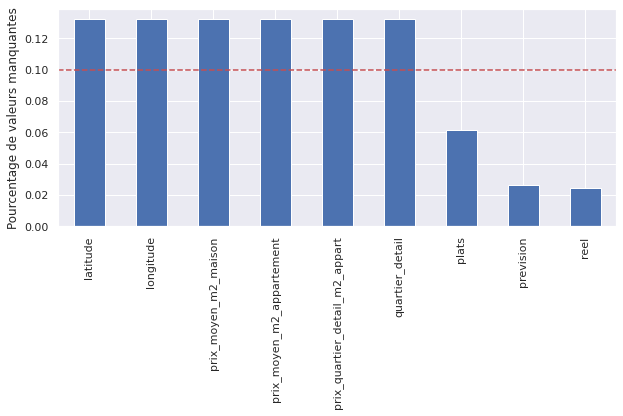

In [38]:
# plot
data[na_feats].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Pourcentage de valeurs manquantes')
plt.axhline(y=0.10, color='r', linestyle='--')
plt.show()

Les pourcentages de valeurs manquantes restent relativement faibles, ainsi, nous pourrons procéder à une imputation afin de permettre la modélisation. Il est interéssant de noter que ce ne sont que des variables numériques.

### Explorons la relation entre les valeurs manquantes et la cible

In [39]:

def analyse_na_value(df, var):

    # copy of the dataframe, so that we do not override the original data
    df = df.copy()

    # let's make a temp var where 1 if missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)['reel'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Relation entre la cible et la valeur manquante", color='goldenrod')

    plt.show()

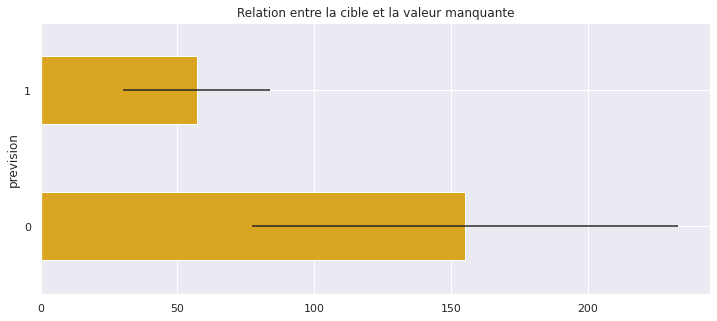

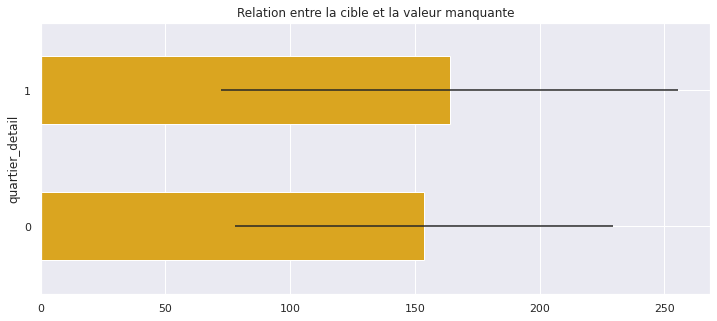

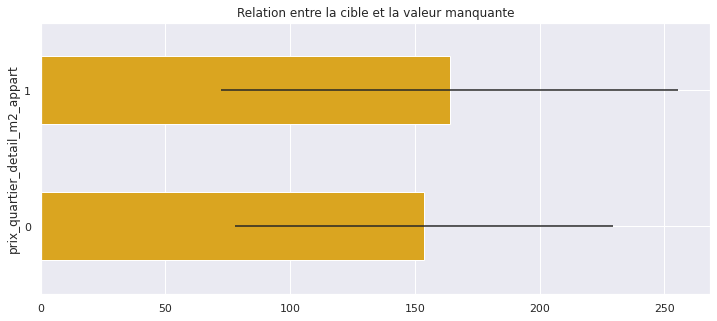

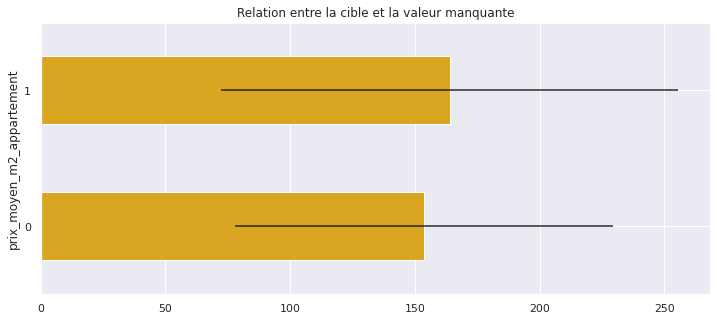

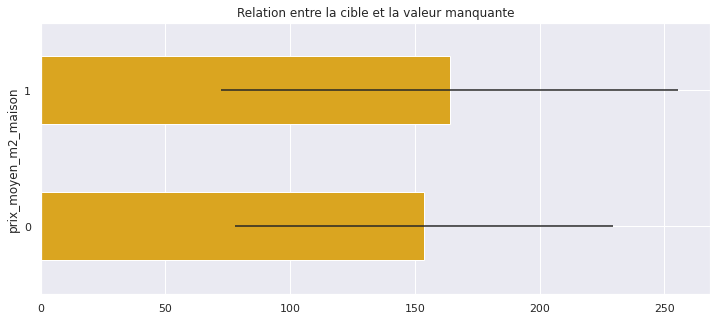

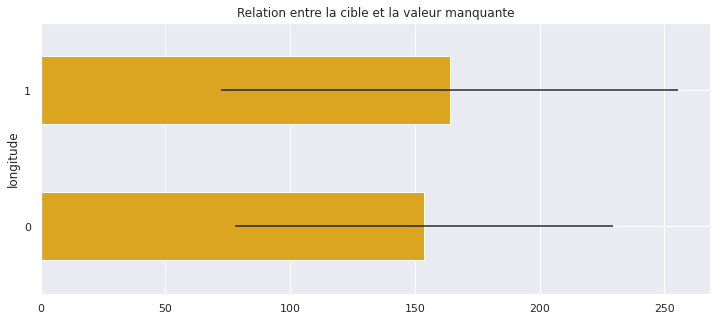

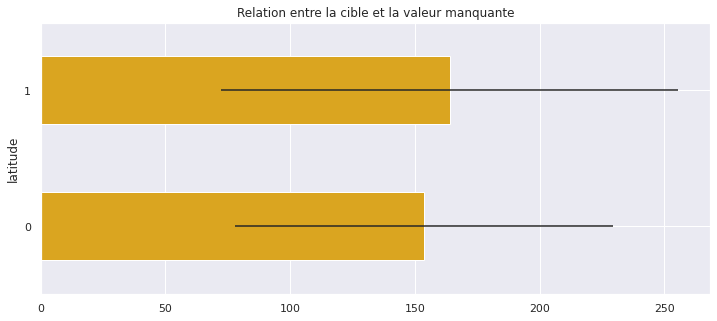

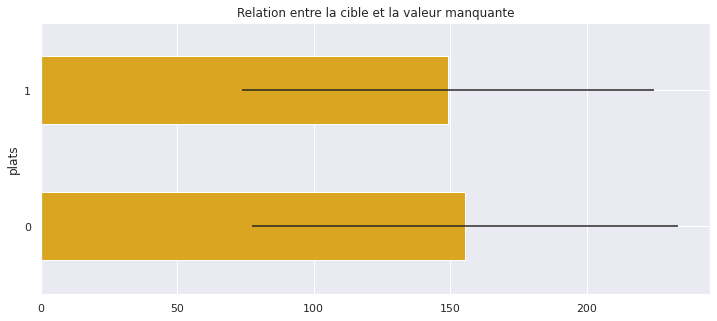

In [40]:
for var in na_feats:
    if var != 'reel':
        analyse_na_value(data, var)

Il semblerait que le fait que la prévision soit manquante impacte fortement la cible. Une variable indiqant la présence ou l'absence de prévisions pourrait être informative. Les valeurs manquantes chez les autres variables semblent aussi plus modestement informatives.

## Les variables numériques

In [41]:
print('Nombre de variables numériques : ', len(num_feats))
data[num_feats].head()

Nombre de variables numériques :  25


,prevision,effectif,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,vacances_dans,depuis_vacances,plats,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve
0,210.0,191,3143.0,3208.0,3333.0,1.5795,47.2652,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
1,100.0,149,4200.0,4430.0,4376.0,1.5609,47.2122,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
2,267.0,124,3207.0,3089.0,4189.0,1.5418,47.2029,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
3,197.0,334,NaN,NaN,NaN,NaN,NaN,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0
4,271.0,116,4131.0,3741.0,4792.0,1.5765,47.2263,54,0,hachis parmentier pamplemousse salade verte fl...,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0


Parmis ces variables numériques, il y a en faites des variables de type booléennes (ramandan, greve...), d'autres de types géographiques (longitude, latitude) et enfin des variables de type temporelles (vacances_dans, depuis_vacances...). Et bien sûr, des variables discrètes et continues.

### Les variables discrètes

In [42]:
#  a neat abitrary trick to find discrete features
discrete_feats = [var for var in num_feats if len(
    data[var].unique()) < 30]

discrete_feats

['prix_quartier_detail_m2_appart',
 'chretiennes',
 'juives',
 'ramadan',
 'musulmanes',
 'greve']

Ce sont majoritairement les variables booléennes. Voyons comment elles semblent impacter la frequentation réelle.

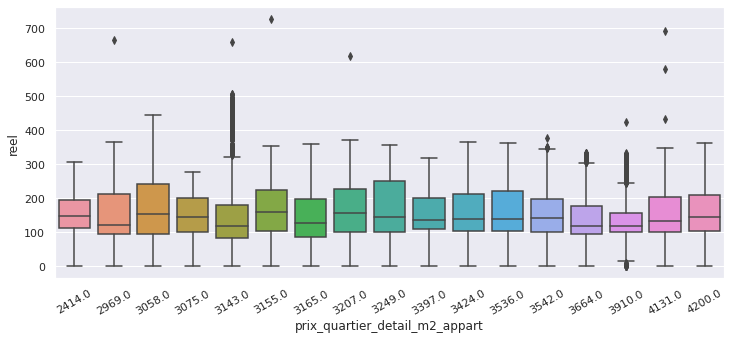

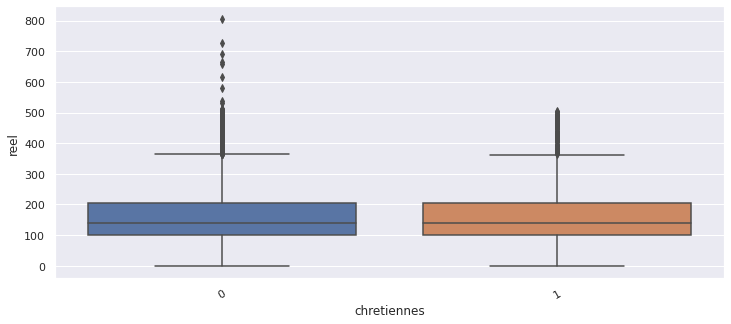

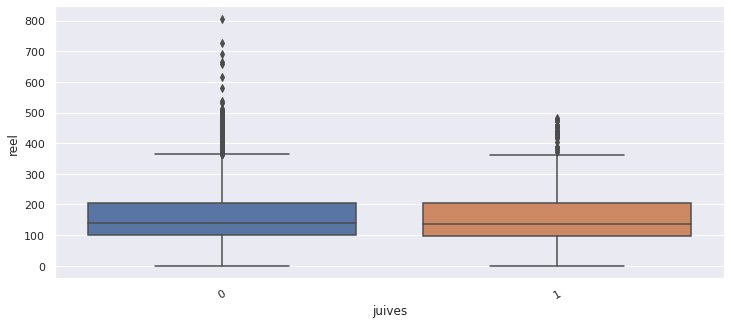

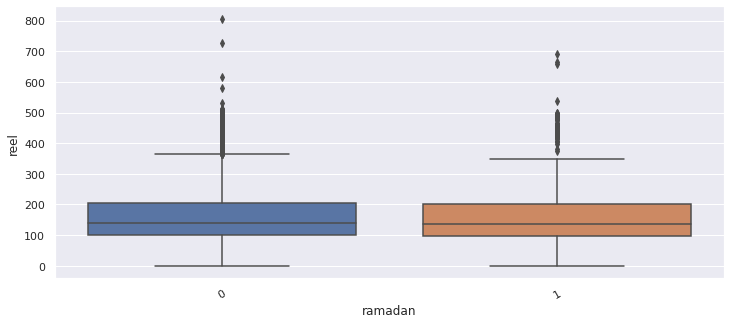

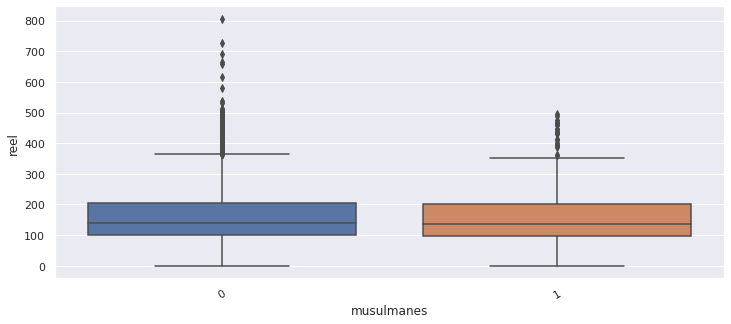

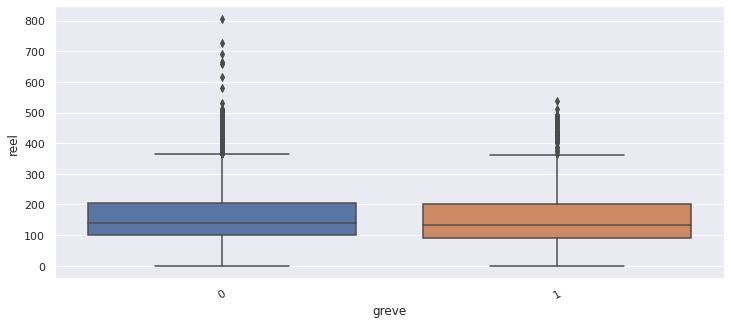

In [43]:
for var in discrete_feats:
    # make boxplot
    ax = sns.boxplot(x=var, y='reel', data=data[data['reel'] < 1000 ])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.show()

Ces variables ne semblent pas avoir, à elles seules, un impact significatif sur la frequentation...

### Les variables continues

In [44]:
continuous_feats = [
    var for var in num_feats if var not in discrete_feats]

continuous_feats

['prevision',
 'effectif',
 'prix_moyen_m2_appartement',
 'prix_moyen_m2_maison',
 'longitude',
 'latitude',
 'vacances_dans',
 'depuis_vacances',
 'plats',
 'ferie_dans',
 'depuis_ferie',
 'chretiennes_dans',
 'depuis_chretiennes',
 'juives_dans',
 'depuis_juives',
 'ramadan_dans',
 'depuis_ramadan',
 'musulmanes_dans',
 'depuis_musulmanes']

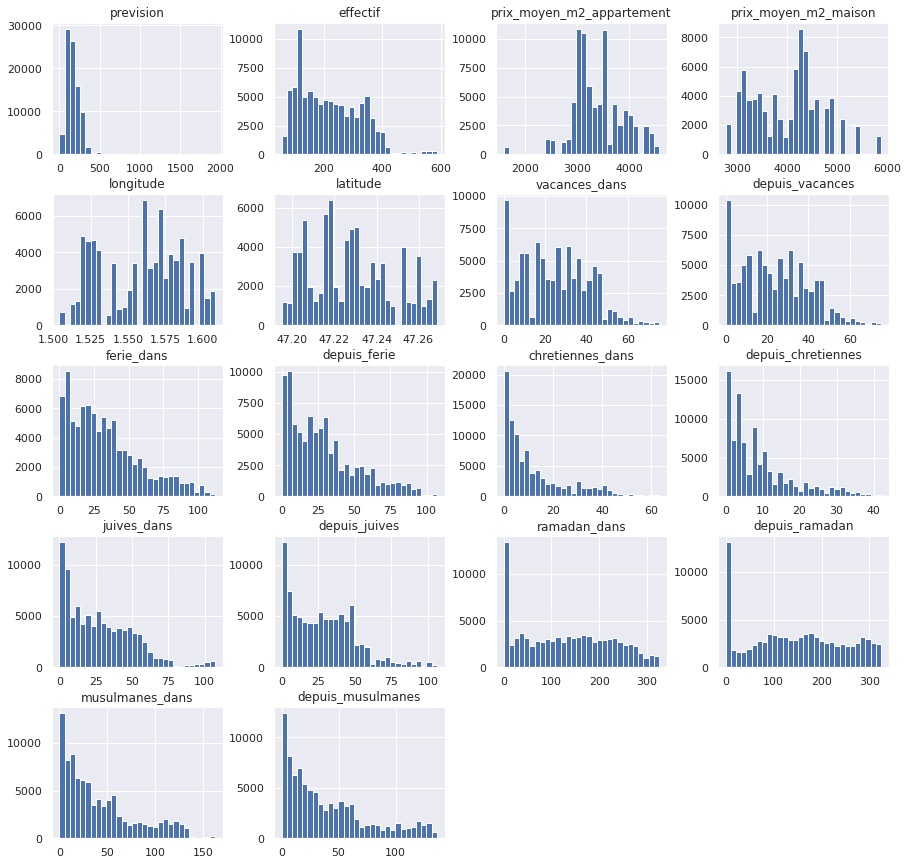

In [45]:
# plot histograms for continuous variables
data[continuous_feats].hist(bins=30, figsize=(15,15))
plt.show()

Les variables ne sont pas normalement distribuées. Et il y en a quelques-unes en particulier qui sont extrêmement asymétriques comme 'prevision'. Il est tout à fait logique que les variables temporelles soit asymétriques.

Parfois, la transformation des variables pour améliorer la répartition des valeurs améliore les performances du modèle, en particulier dans le cas d'un modèle linéaire. Mais il est peu probable qu'une transformation permette de modifier de façon spectaculaire la distribution des variables très asymétriques.

Pour les variables strictement positives, on peut appliquer une transformation logarithmiques. Pour les autres, il existe d'autres transformations statistiques applicables. Cependant ici, beaucoup de variables ont des valeurs nulles et le loarithme n'est pas applicable. On peut utiliser la transformation de yeo-johnson.

In [46]:
skew_feats = ['prevision', 'vacances_dans', 'depuis_vacances',
              'ferie_dans', 'depuis_ferie', 'chretiennes_dans', 'depuis_chretiennes',
              'juives_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan',
              'musulmanes_dans', 'depuis_musulmanes']

In [47]:
# don't override the dataset
tmp = data.copy()q
for var in skew_feats:
    tmp[var], param = stats.yeojohnson(data[var])

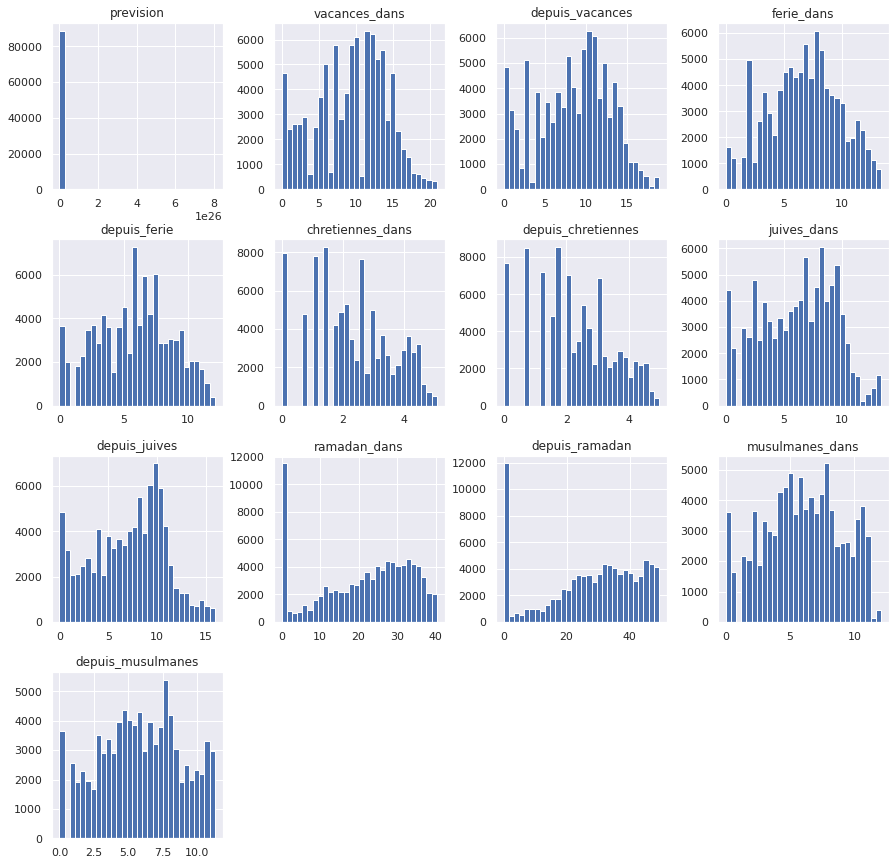

In [48]:
# plot histograms after transformation
tmp[skew_feats].hist(bins=30, figsize=(15,15))
plt.show()

La transformation n'a pas fonctionné pour la variable 'prevision'. Cependant, elle semble satisfaisante pour les autres variables. 

Il reste à voir si cela permet d'améliorer le pouvoir prédictif. Pour déterminer si c'est le cas, nous devrons entraîner un modèle avec les valeurs originales et un autre avec les valeurs transformées, et déterminer la performance du modèle et l'importance des features.

On peut également comparer la relation entre la cible est les variables d'origines ainsi que les variables transformées.

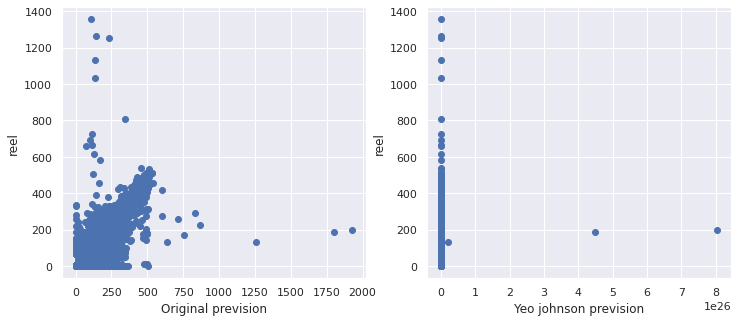

In [49]:
# original or transformed prevision vs reel

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.scatter(data['prevision'],data['reel'])
plt.ylabel('reel')
plt.xlabel('Original prevision')
plt.subplot(1, 2, 2)
plt.scatter(tmp['prevision'],tmp['reel'])
plt.ylabel('reel')
plt.xlabel('Yeo johnson prevision')        
plt.show()

Comme on peut le voir et en toute logique, la prevision semble être corrélée avec le réel, mais Yeo jhonson ne doit pas être appliqué à cette variable.

## Les variables qualitatives

### La cardinalité

<AxesSubplot:>

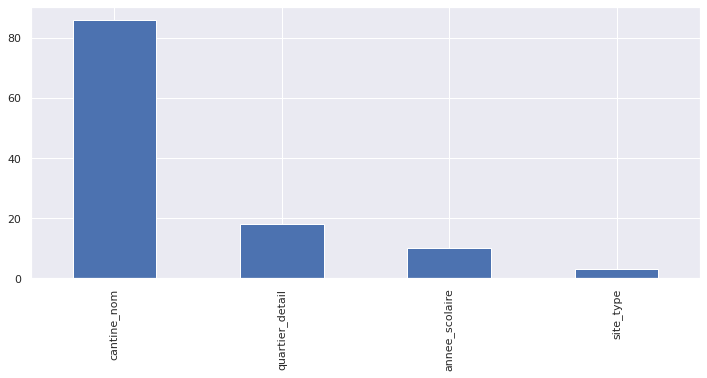

In [50]:
# count unique categories and them in descending order
data[cat_feats].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

cantine_nom a une très haute cardinalité, avec plus de 80 cantines différentes. En conséquence, il faudra garder cela en tête lors de l'encoding.

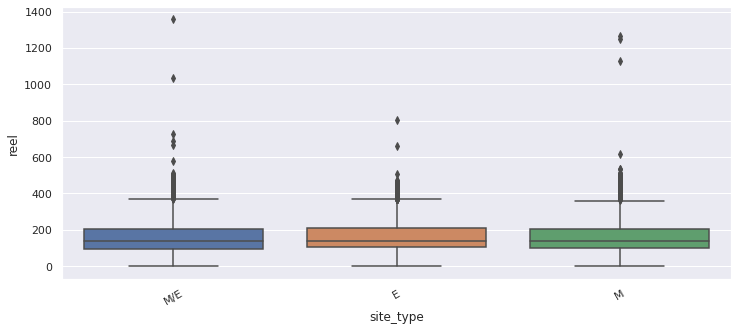

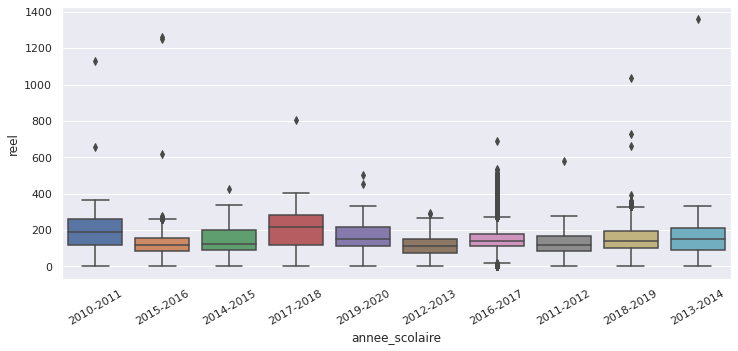

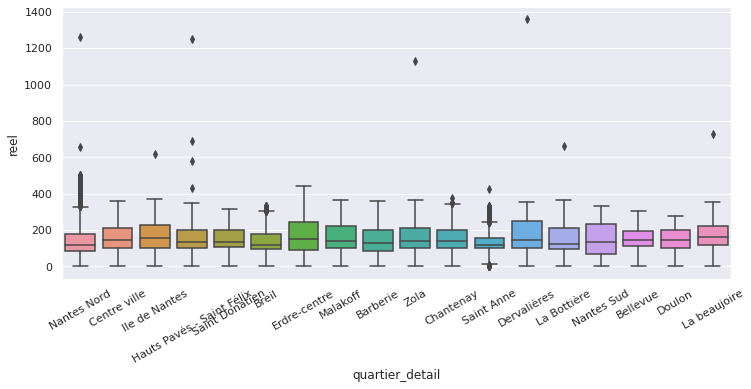

In [51]:
# relationship with target

for var in cat_feats:
    if var != 'cantine_nom':
        # make boxplot
        ax = sns.boxplot(x=var, y='reel', data=data)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        plt.show()

Le type de site ne semble pas avoir d'impact sur la frequentation, à l'inverse de l'année scolaire et plus généralement de la temporalité et du quartier dans lequel ce situe la cantine.

### Les catégories à faible effectif

In [52]:
def rare_labels(df, var, thresh):
    
    df = df.copy()
    # % of observations per categ
    tmp = df.groupby(var)['reel'].count() / len(df) * 100
    
    # return categ below tresh
    return tmp[tmp < thresh]


for var in cat_feats:
    print(rare_labels(data, var, 1), '\n')

Series([], Name: reel, dtype: float64) 

cantine_nom
AIME CESAIRE         0.871742
ALAIN FOURNIER E     0.828923
BOCCAGE E            0.824532
BOCCAGE M            0.689489
CHATAIGNIERS E       0.722426
CHATAIGNIERS M       0.779517
CHAUVINIERE E        0.833315
CHAUVINIERE M        0.715838
CHENE D'ARON E       0.697174
CHENE D'ARON M       0.859665
COUDRAY E.           0.948596
GASTON SERPETTE E    0.823434
GASTON SERPETTE M    0.805867
GUSTAVE ROCH E       0.847588
GUSTAVE ROCH M       0.753167
JEAN ZAY E           0.646670
JEAN ZAY M           0.657649
MARSAUDERIES E       0.780615
MARSAUDERIES M       0.722426
MAURICE MACE E       0.763049
MAURICE MACE M       0.861861
STALINGRAD E         0.598362
STALINGRAD M         0.870644
Name: reel, dtype: float64 

Series([], Name: reel, dtype: float64) 

quartier_detail
Doulon    0.763049
Name: reel, dtype: float64 



Les cantines sous la barre des 1% du total ne sont pas des outliers car il y a en tout plus de 80 cantines. Les catégories rares de ce dataset ne risque probablement pas de provoquer un quelconque sur apprentissage.

## Requêtes répondant aux questions du métier

- Type de menus les plus récurrents  
- Nb de repas distribués par jour de la semaine en moyenne
- Ventilation des repas par quartier

### Menus

In [53]:
cursor = conn.cursor()
['Frequentation_quotidienne', 'Dim_site',
    'Dim_menu', 'Dim_temporelle', 'Dim_evenement']

SQL_Query = pd.read_sql_query(
    '''select 
Frequentation_quotidienne.date, 
Frequentation_quotidienne.prevision, 
Frequentation_quotidienne.reel,
Dim_menu.plats

from Frequentation_quotidienne
left join Dim_menu               on Frequentation_quotidienne.jour_id = Dim_menu.jour_id

order by Frequentation_quotidienne.jour_site_id
''', conn)

menus = pd.DataFrame(SQL_Query, columns=['date', 'prevision', 'reel', 'plats'])

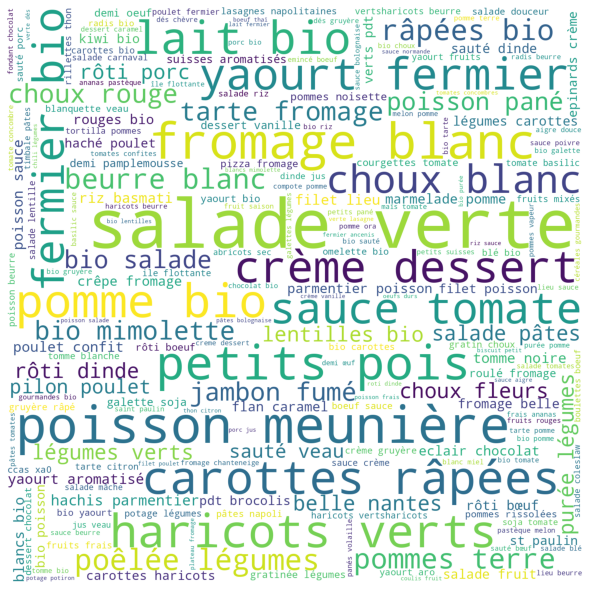

In [86]:
from wordcloud import WordCloud, STOPWORDS


words = ''
stopwords = set(STOPWORDS) 
stopwords.add('none')

for plat in menus.plats:

    plat = str(plat)

    tokens = plat.split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    words += " ".join(tokens) + " "

wordcloud = WordCloud(width=1500, height=1500,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

On observer la présence de menus équilibrés avec beaucoup de légumes verts, de poisson et de produits bio.

A partir de cette représentation visuelle, nous pouvons essayer de constituer différentes features :
- is_meat
- is_green
- is_bio

In [83]:
menus['is_meat'] = np.where(menus['plats'].str.contains(
    'rôti|dinde|jambon|poulet|pilon|boeuf|porc|sauté|veau|boulettes|parmentier|bolognaise'), 1, 0)

In [87]:
menus['is_green'] = np.where(menus['plats'].str.contains(
    'haricots|salade|légumes|choux|courgettes||brocolis|lentilles|carottes'), 1, 0)
menus['is_bio'] = np.where(menus['plats'].str.contains('bio'), 1, 0)
menus['is_fries'] = np.where(menus['plats'].str.contains('frites'), 1, 0)
menus['is_fish'] = np.where(menus['plats'].str.contains('poisson|meunière|'), 1, 0)

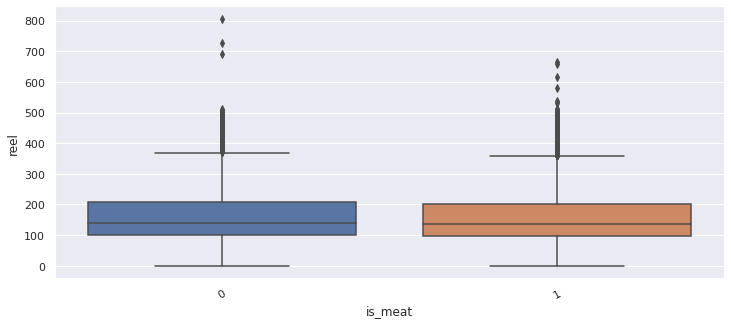

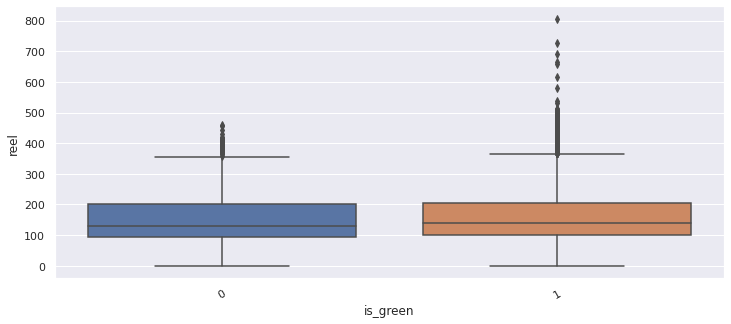

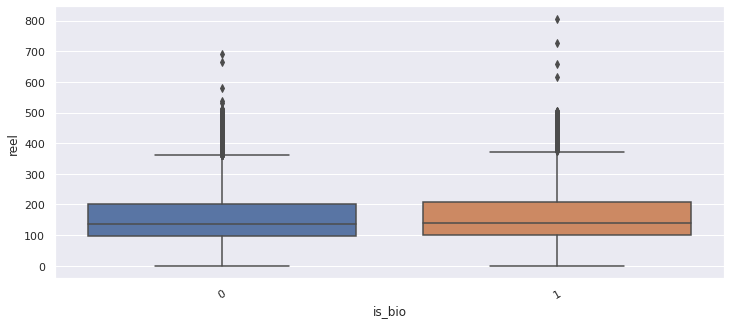

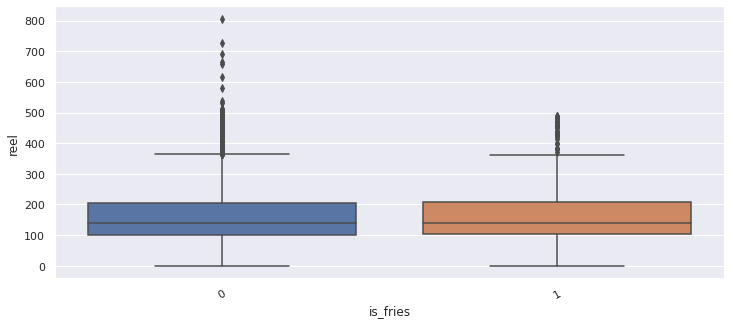

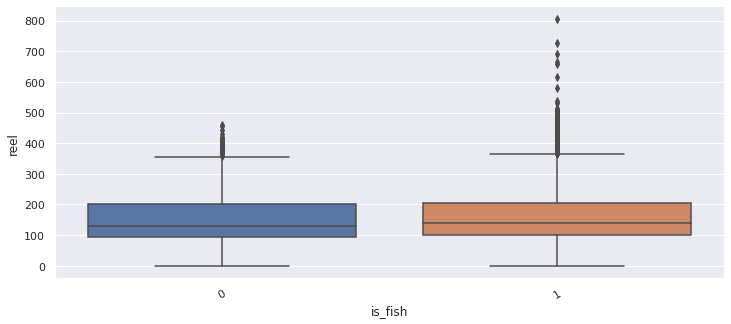

In [96]:
menu_feats = ['is_meat', 'is_green', 'is_bio', 'is_fries', 'is_fish']

for var in menu_feats:
    # make boxplot
    ax = sns.boxplot(x=var, y='reel', data=menus[menus['reel'] < 1000 ])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.show()

A première vue, ces variables ne semblent pas très informatives quand à la fréquentation.

### Fréquentation par jours de la semaine et du mois 

In [111]:
cursor = conn.cursor()
['Frequentation_quotidienne', 'Dim_site',
    'Dim_menu', 'Dim_temporelle', 'Dim_evenement']

SQL_Query = pd.read_sql_query(
    '''select 
Frequentation_quotidienne.date, 
strftime("%w",Frequentation_quotidienne.date) as weekday,
strftime("%d",Frequentation_quotidienne.date) as monthday,
Frequentation_quotidienne.prevision, 
Frequentation_quotidienne.reel

from Frequentation_quotidienne

order by Frequentation_quotidienne.date
''', conn)


days = pd.DataFrame(SQL_Query, columns=['date', 'weekday', 'monthday', 'prevision', 'reel'])

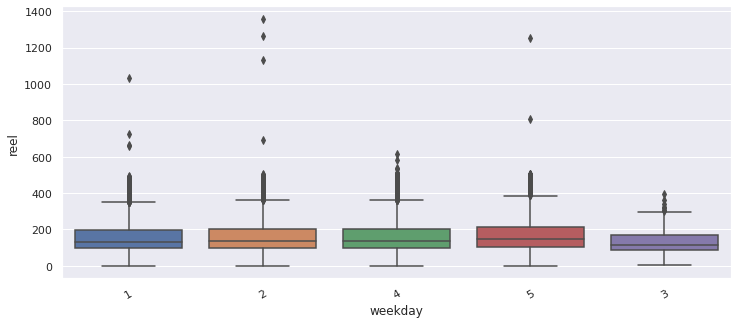

In [107]:
ax = sns.boxplot(x='weekday', y='reel', data=days)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

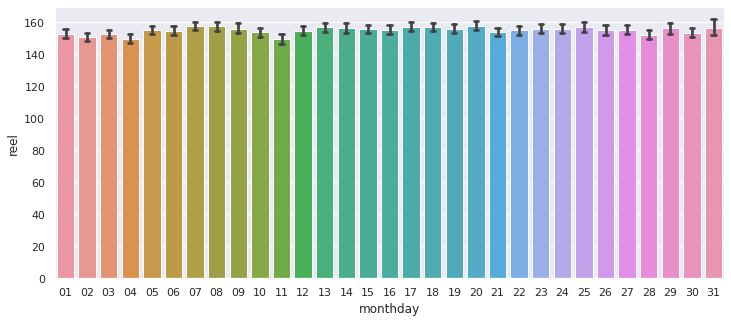

In [118]:
ax = sns.barplot(data=days, x="monthday", y="reel", capsize=.2, order=['01', '02', '03', '04', '05', '06', '07', '08',
                                                                       '09', '10', '11', '12', '13', '14', '15', '16',
                                                                       '17', '18', '19', '20', '21', '22', '23', '24',
                                                                       '25', '26', '27', '28', '29', '30', '31'])
plt.show()

La fréquentation semble logiquement plus basse le mercredi. En revanche, on ne détecte pas spécialement un effet mensuel.